In [1]:
import numpy as np
import pandas as pd
import fastmeteo
from traffic.core import Traffic, Flight
from openap import aero
import openap
import contrail
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy.feature import OCEAN, LAND, BORDERS

import matplotlib
matplotlib.rc("font", size=12)
matplotlib.rc("font", family="Ubuntu")
matplotlib.rc("lines", linewidth=2, markersize=8)
matplotlib.rc("grid", color="darkgray", linestyle=":")

pd.options.display.max_columns=100

import warnings

warnings.filterwarnings("ignore")

In [2]:
sample_flight_full = pd.read_csv("data/example_flight.csv", parse_dates=["timestamp"])

In [3]:
fmg = fastmeteo.Grid(local_store="/tmp/era5-zarr/")

In [4]:
sample_flight_new = fmg.interpolate(sample_flight_full)
sample_flight_new.head(3)

,timestamp,icao24,typecode,callsign,origin,destination,latitude,longitude,altitude,groundspeed,track,vertical_rate,u_component_of_wind,v_component_of_wind,temperature,specific_humidity
0,2018-01-02 19:53:00+00:00,3.946000e+12,a319,AFR91HL,LBG,BMA,49.085861,2.349666,8200.0,255.0,327.804266,1920.0,NaN,NaN,NaN,NaN
1,2018-01-02 19:54:00+00:00,3.946000e+12,a319,AFR91HL,LBG,BMA,49.153427,2.310861,9475.0,290.0,9.722018,960.0,NaN,NaN,NaN,NaN
2,2018-01-02 19:55:00+00:00,3.946000e+12,a319,AFR91HL,LBG,BMA,49.233367,2.361121,9975.0,332.0,23.243919,640.0,22.358671,0.770471,269.287284,0.002346


In [5]:
flight = Flight(sample_flight_new.assign(
    vgx = lambda d: d.groundspeed * np.sin(np.radians(d.track)) * aero.kts,
    vgy = lambda d: d.groundspeed * np.cos(np.radians(d.track)) * aero.kts,
    vax = lambda d: d.vgx-d.u_component_of_wind,
    vay = lambda d: d.vgy-d.v_component_of_wind,
    TAS = lambda d: np.sqrt(d.vax**2 + d.vay**2) / aero.kts
))

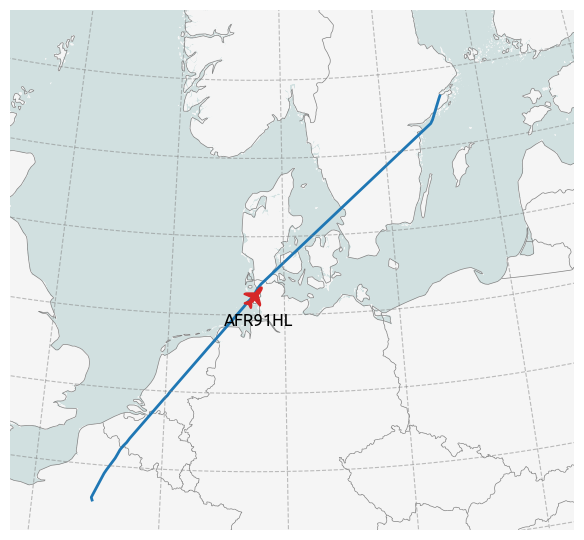

In [6]:
fig = plt.figure(figsize=(6, 6), constrained_layout=True)


ax1 = fig.add_subplot(
    111,
    projection=ccrs.Orthographic(
        central_longitude=flight.longitude_median,
        central_latitude=flight.latitude_median,
    ),
)

ax1.set_extent(
    [
        flight.longitude_min - 3,
        flight.longitude_max + 3,
        flight.latitude_min - 1,
        flight.latitude_max + 2,
    ]
)
ax1.add_feature(OCEAN, facecolor="#d1e0e0", zorder=-1, lw=0)
ax1.add_feature(LAND, facecolor="#f5f5f5", lw=0)
ax1.add_feature(BORDERS, lw=0.5, color="gray")
ax1.coastlines(resolution="50m", lw=0.5, color="gray")
ax1.gridlines(draw_labels=False, color="gray", alpha=0.5, ls="--")


# trajectory
ax1.plot(
    flight.data.longitude,
    flight.data.latitude,
    color="tab:blue",
    transform=ccrs.Geodetic(),
    lw=2,
)

flight.at_ratio(0.5).plot(
    ax1, color="tab:red", shift=dict(units="dots", y=-30, x=-30), zorder=10
)

ax1.spines["geo"].set_visible(False)

plt.tight_layout()
plt.show()

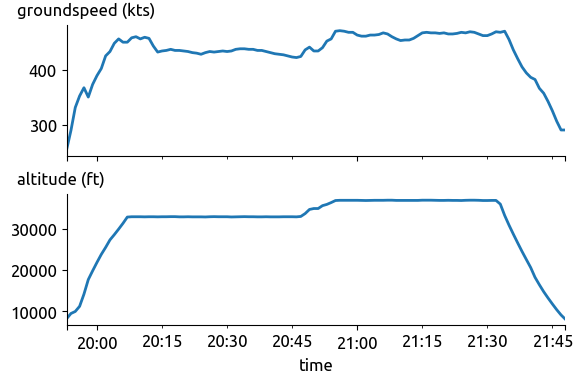

In [7]:

fig = plt.figure(figsize=(6, 4), constrained_layout=True)

ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(212, sharex=ax2)

flight.plot_time(y="groundspeed", ax=ax2, label="ground speed")
# flight.plot_time(y="TAS", ax=ax2, label="airspeed")

flight.plot_time(y="altitude", ax=ax3)

ax2.set_ylabel("groundspeed (kts)", rotation=0, ha="left")
ax3.set_ylabel("altitude (ft)", rotation=0, ha="left")
ax3.set_xlabel("time")

for ax in (ax2, ax3):
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_label_coords(-0.1, 1.05)
    ax.get_legend().remove()

plt.tight_layout()
plt.show()


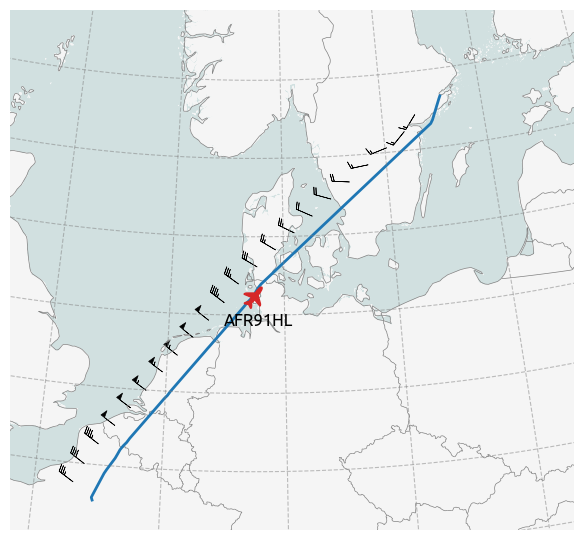

In [8]:

fig = plt.figure(figsize=(6, 6), constrained_layout=True)


ax1 = fig.add_subplot(
    111,
    projection=ccrs.Orthographic(
        central_longitude=flight.longitude_median,
        central_latitude=flight.latitude_median,
    ),
)

ax1.set_extent(
    [
        flight.longitude_min - 3,
        flight.longitude_max + 3,
        flight.latitude_min - 1,
        flight.latitude_max + 2,
    ]
)

ax1.add_feature(OCEAN, facecolor="#d1e0e0", zorder=-1, lw=0)
ax1.add_feature(LAND, facecolor="#f5f5f5", lw=0)
ax1.add_feature(BORDERS, lw=0.5, color="gray")
ax1.coastlines(resolution="50m", lw=0.5, color="gray")
ax1.gridlines(draw_labels=False, color="gray", alpha=0.5, ls="--")

ax1.barbs(
    flight.data.longitude[::5]-1,
    flight.data.latitude[::5],
    flight.data.u_component_of_wind[::5],
    flight.data.v_component_of_wind[::5],
    transform=ccrs.PlateCarree(),
    color="k",
    length=5,
    lw=0.5,
)

# trajectory
ax1.plot(
    flight.data.longitude,
    flight.data.latitude,
    color="tab:blue",
    transform=ccrs.Geodetic(),
    lw=2,
)

flight.at_ratio(0.5).plot(
    ax1, color="tab:red", shift=dict(units="dots", y=-30, x=-30), zorder=10
)

ax1.spines["geo"].set_visible(False)

plt.tight_layout()
plt.show()


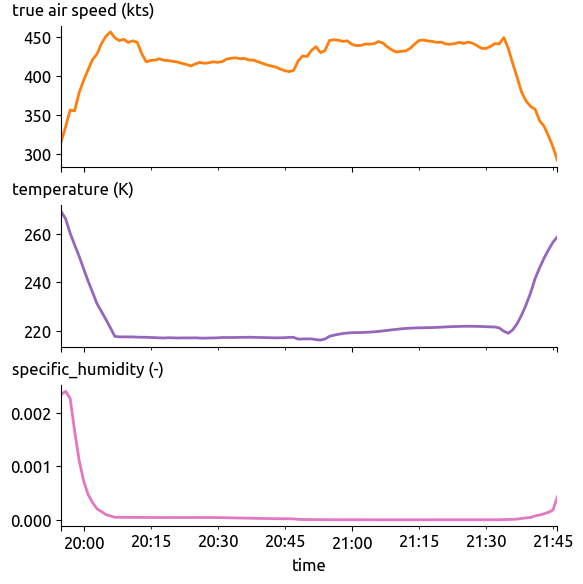

In [9]:
fig = plt.figure(figsize=(6, 6), constrained_layout=True)

ax2 = fig.add_subplot(311)
# ax3 = fig.add_subplot(312, sharex=ax2)
ax4 = fig.add_subplot(312, sharex=ax2)
ax5 = fig.add_subplot(313, sharex=ax2)

flight.plot_time(y="TAS", ax=ax2, color="tab:orange")
flight.plot_time(y="altitude", ax=ax3)
flight.plot_time(y="temperature", ax=ax4, color="tab:purple")
flight.plot_time(y="specific_humidity", ax=ax5, color="tab:pink")

ax2.set_ylabel("true air speed (kts)", rotation=0, ha="left")
# ax3.set_ylabel("altitude (ft)", rotation=0, ha="left")
ax4.set_ylabel("temperature (K)", rotation=0, ha="left")
ax5.set_ylabel("specific_humidity (-)", rotation=0, ha="left")


ax5.set_xlabel("time")

for ax in (ax2, ax4, ax5):
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_label_coords(-0.1, 1.05)
    ax.get_legend().remove()


plt.tight_layout()
plt.show()


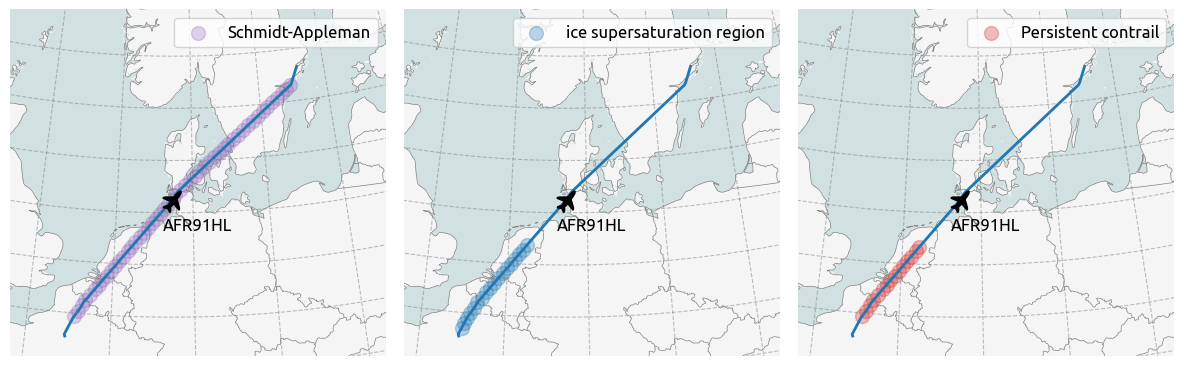

In [12]:
flight_ = flight.assign(
    rhi=lambda d: contrail.relative_humidity(
        d.specific_humidity,
        openap.aero.pressure(d.altitude * openap.aero.ft),
        d.temperature,
        to="ice",
    ),
    crit_temp=lambda d: contrail.critical_temperature_water(
        openap.aero.pressure(d.altitude * openap.aero.ft)
    ),
    sac=lambda d: d.temperature < d.crit_temp,
    issr=lambda d: d.rhi > 1,
    persistent = lambda d: d.sac & d.issr
)

fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(12, 4), 
    subplot_kw={'projection': ccrs.Orthographic(
        central_longitude=flight_.longitude_median,
        central_latitude=flight_.latitude_median,
    )}
)

for ax in (ax1, ax2, ax3):
    ax.set_extent(
        [
            flight_.longitude_min - 3,
            flight_.longitude_max + 3,
            flight_.latitude_min - 1,
            flight_.latitude_max + 2,
        ]
    )
    ax.add_feature(OCEAN, facecolor="#d1e0e0", zorder=-1, lw=0)
    ax.add_feature(LAND, facecolor="#f5f5f5", lw=0)
    ax.add_feature(BORDERS, lw=0.5, color="gray")
    ax.coastlines(resolution="50m", lw=0.5, color="gray")
    ax.gridlines(draw_labels=False, color="gray", alpha=0.5, ls="--")

    ax.plot(
        flight_.data.longitude,
        flight_.data.latitude,
        color="tab:blue",
        transform=ccrs.Geodetic(),
        lw=2,
    )

    flight_.at_ratio(0.5).plot(
        ax, color="k", shift=dict(units="dots", y=-30, x=-10), zorder=10
    )


    ax.spines["geo"].set_visible(False)


ax1.scatter(
    flight_.query("sac").data.longitude[::2],
    flight_.query("sac").data.latitude[::2],
    color="tab:purple",
    s=100,
    alpha=0.3,
    transform=ccrs.Geodetic(),
    label="Schmidt-Appleman"
)

ax2.scatter(
    flight_.query("issr").data.longitude[::2],
    flight_.query("issr").data.latitude[::2],
    color="tab:blue",
    s=100,
    alpha=0.3,
    transform=ccrs.Geodetic(),
    label="ice supersaturation region"
)

ax3.scatter(
    flight_.query("persistent").data.longitude[::2],
    flight_.query("persistent").data.latitude[::2],
    color="tab:red",
    s=100,
    alpha=0.3,
    transform=ccrs.Geodetic(),
    label="Persistent contrail"
)

for ax in (ax1, ax2, ax3):
    ax.legend()

plt.tight_layout()
plt.show()


232.38801704974253
225.86592333777426


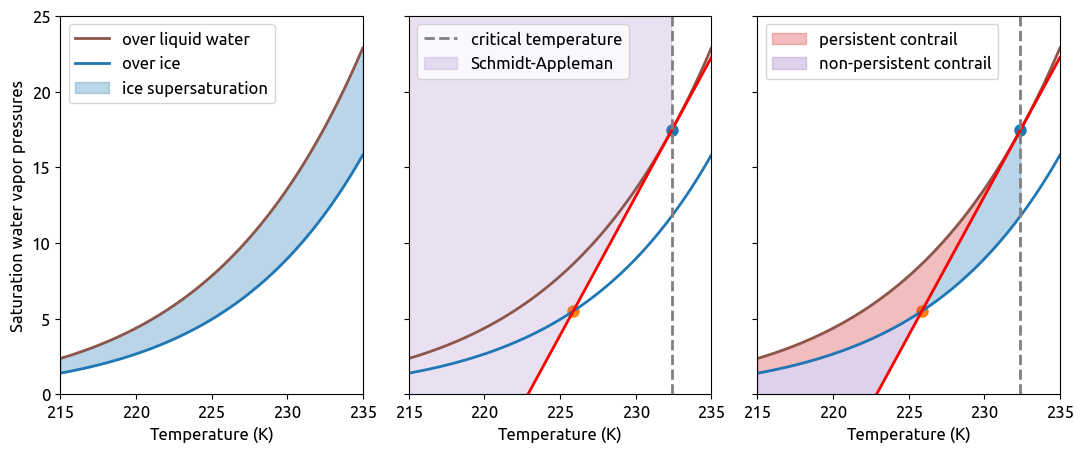

In [14]:
pressure = 24000

crit_temp_water, crit_temp_ice = contrail.critical_temperature_water_and_ice(pressure)

print(crit_temp_water)
print(crit_temp_ice)

temperatures = np.linspace(215, 235, 100)

coef_fitted = np.polyfit(
    [crit_temp_ice, crit_temp_water],
    [
        contrail.saturation_pressure_over_ice(crit_temp_ice),
        contrail.saturation_pressure_over_water(crit_temp_water),
    ],
    1,
)

tangent_line = np.poly1d(coef_fitted)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5), sharey=True)

ax1.plot(
    temperatures,
    contrail.saturation_pressure_over_water(temperatures),
    label="over liquid water",
    color="tab:brown",
)
ax1.plot(
    temperatures,
    contrail.saturation_pressure_over_ice(temperatures),
    label="over ice",
    color="tab:blue",
)
ax1.fill_between(
    temperatures,
    contrail.saturation_pressure_over_ice(temperatures),
    contrail.saturation_pressure_over_water(temperatures),
    color="tab:blue",
    alpha=0.3,
    label="ice supersaturation",
)

ax1.set_ylabel("Saturation water vapor pressures")


ax2.plot(
    temperatures,
    contrail.saturation_pressure_over_water(temperatures),
    color="tab:brown",
)
ax2.plot(
    temperatures, contrail.saturation_pressure_over_ice(temperatures), color="tab:blue"
)
ax2.scatter(crit_temp_water, contrail.saturation_pressure_over_water(crit_temp_water))
ax2.scatter(crit_temp_ice, contrail.saturation_pressure_over_ice(crit_temp_ice))
ax2.plot(temperatures, tangent_line(temperatures), color="red")
ax2.axvline(x=crit_temp_water, ls="--", color="gray", label="critical temperature")
ax2.fill_between(
    np.linspace(temperatures[0], crit_temp_water, 20),
    tangent_line(np.linspace(temperatures[0], crit_temp_water, 20)),
    30,
    color="tab:purple",
    alpha=0.2,
    label="Schmidt-Appleman",
)


ax3.plot(
    temperatures,
    contrail.saturation_pressure_over_water(temperatures),
    color="tab:brown",
)
ax3.plot(
    temperatures, contrail.saturation_pressure_over_ice(temperatures), color="tab:blue"
)
ax3.scatter(crit_temp_water, contrail.saturation_pressure_over_water(crit_temp_water))
ax3.scatter(crit_temp_ice, contrail.saturation_pressure_over_ice(crit_temp_ice))
ax3.plot(temperatures, tangent_line(temperatures), color="red")

temp_below_water = temperatures[temperatures < crit_temp_water]
temp_below_ice = temperatures[temperatures < crit_temp_ice]
temp_between_ice_water = temperatures[
    (temperatures < crit_temp_water) & (crit_temp_ice < temperatures)
]

ax3.fill_between(
    temp_below_water,
    np.maximum(
        tangent_line(temp_below_water),
        contrail.saturation_pressure_over_ice(temp_below_water),
    ),
    contrail.saturation_pressure_over_water(temp_below_water),
    color="tab:red",
    alpha=0.3,
    label="persistent contrail",
)

ax3.fill_between(
    temp_below_ice,
    tangent_line(temp_below_ice),
    contrail.saturation_pressure_over_ice(temp_below_ice),
    color="tab:purple",
    alpha=0.3,
    label="non-persistent contrail",
)

ax3.fill_between(
    temp_between_ice_water,
    tangent_line(temp_between_ice_water),
    contrail.saturation_pressure_over_ice(temp_between_ice_water),
    color="tab:blue",
    alpha=0.3,
    # label="contrail spreading",
)

ax3.axvline(x=crit_temp_water, ls="--", color="gray")


for ax in (ax1, ax2, ax3):
    ax.legend()
    ax.set_ylim(0, 25)
    ax.set_xlim(temperatures[0], temperatures[-1])
    ax.set_aspect(1)
    ax.set_xlabel("Temperature (K)")



plt.tight_layout()
plt.show()